<a href="https://colab.research.google.com/github/ravish31/pyspark_mllib/blob/main/Group05_IrisDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part - 2 of Assignment**

In [ ]:
!pip install pyspark

# **1.	Import Libraries/Dataset**

In [ ]:
import pyspark as sp

sc = sp.SparkContext.getOrCreate()
print(sc)
print(sc.version)

<SparkContext master=local[*] appName=pyspark-shell>
3.5.0


In [ ]:
import numpy as np
import zipfile
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col,isnan, when, count, lit
from pyspark.ml.feature import MinMaxScaler,StandardScaler
import urllib.request
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
rnd_seed=123
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [ ]:
urllib.request.urlretrieve("https://archive.ics.uci.edu/static/public/53/iris.zip", "iris.zip")
with zipfile.ZipFile('./iris.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
#Create my_spark
spark = SparkSession.builder.getOrCreate()

#print my_spark
print(spark)

# **2.	Data Visualization and Exploration**                                         
a.	Print at least 5 rows for sanity check to identify all the features present in the dataset and if the target matches with them.

b.	Print the description and shape of the dataset.

c.	Provide appropriate visualization to get an insight about the dataset.

d.	Try exploring the data and see what insights can be drawn from the dataset.



In [ ]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("sepalLength", FloatType(), nullable=True),
    StructField("sepalWidth", FloatType(), nullable=True),
    StructField("petalLength", FloatType(), nullable=True),
    StructField("petalWidth", FloatType(), nullable=True),
    StructField("Class", StringType(), nullable=True)]
)
iris_df = spark.read.csv(path='./iris.data', schema=schema).cache()

In [ ]:
iris_df.show(5)

+-----------+----------+-----------+----------+-----------+
|sepalLength|sepalWidth|petalLength|petalWidth|      Class|
+-----------+----------+-----------+----------+-----------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|
|        4.9|       3.0|        1.4|       0.2|Iris-setosa|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|
|        5.0|       3.6|        1.4|       0.2|Iris-setosa|
+-----------+----------+-----------+----------+-----------+
only showing top 5 rows



In [ ]:
iris_df.columns

['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'Class']

<Axes: xlabel='sepalLength', ylabel='sepalWidth'>

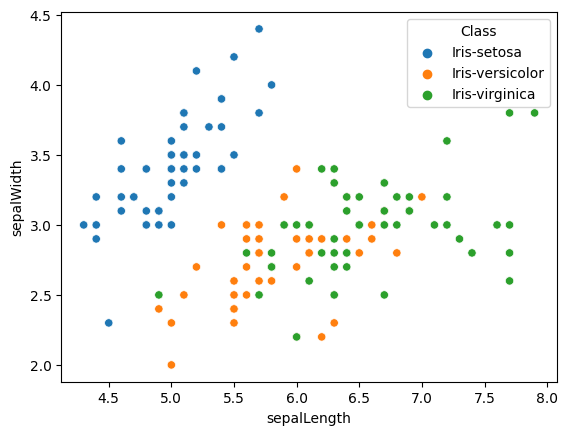

In [ ]:
sns.scatterplot(x='sepalLength', y='sepalWidth',
                hue='Class', data=iris_df.toPandas(), )

# **There seems to be high correlation between petal length and petal width**
We can confirm with correlation heatmap in following cells

<Axes: xlabel='petalLength', ylabel='petalWidth'>

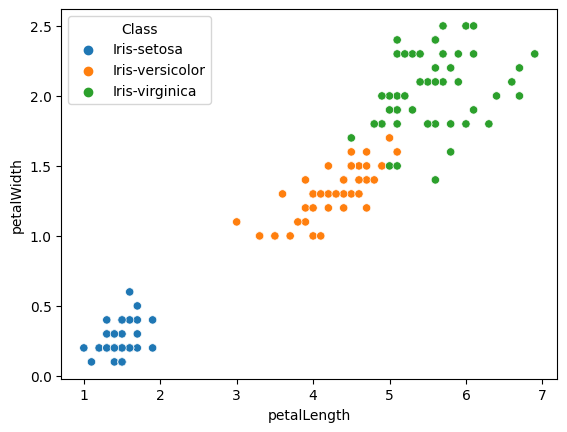

In [ ]:
sns.scatterplot(x='petalLength', y='petalWidth',
                hue='Class', data=iris_df.toPandas(), )

In [ ]:
iris_df.select('Class').distinct().show()

+---------------+
|          Class|
+---------------+
| Iris-virginica|
|    Iris-setosa|
|Iris-versicolor|
+---------------+



In [ ]:
iris_df.describe().show()


+-------+------------------+-------------------+------------------+------------------+--------------+
|summary|       sepalLength|         sepalWidth|       petalLength|        petalWidth|         Class|
+-------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|                150|               150|               150|           150|
|   mean| 5.843333326975505| 3.0540000025431313|3.7586666552225747| 1.198666658103466|          NULL|
| stddev|0.8280661128539085|0.43359431104332985|1.7644204144315179|0.7631607319020202|          NULL|
|    min|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+-------------------+------------------+------------------+--------------+



In [ ]:
#shape of dataframe
print("shape : ",iris_df.count(),',',len(iris_df.columns))

shape :  150 , 5


# **3.	Data Pre-processing and cleaning**
a.	Do the appropriate preprocessing of the data like identifying NULL or Missing Values if any, handling of outliers if present in the dataset, skewed data etc. Apply appropriate feature engineering techniques for them.

b.	Apply the feature transformation techniques like Standardization, Normalization, etc. You are free to apply the appropriate transformations depending upon the structure and the complexity of your dataset.

c.	Do the correlational analysis on the dataset. Provide a visualization for the same.


# **No missing values**

In [ ]:
iris_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in iris_df.columns]
   ).show()

+-----------+----------+-----------+----------+-----+
|sepalLength|sepalWidth|petalLength|petalWidth|Class|
+-----------+----------+-----------+----------+-----+
|          0|         0|          0|         0|    0|
+-----------+----------+-----------+----------+-----+



# **Data set is balanced, all 3 classes have equal no of rows**

In [ ]:
iris_df.groupBy('Class').count().show()

+---------------+-----+
|          Class|count|
+---------------+-----+
| Iris-virginica|   50|
|    Iris-setosa|   50|
|Iris-versicolor|   50|
+---------------+-----+



# **Outliers**

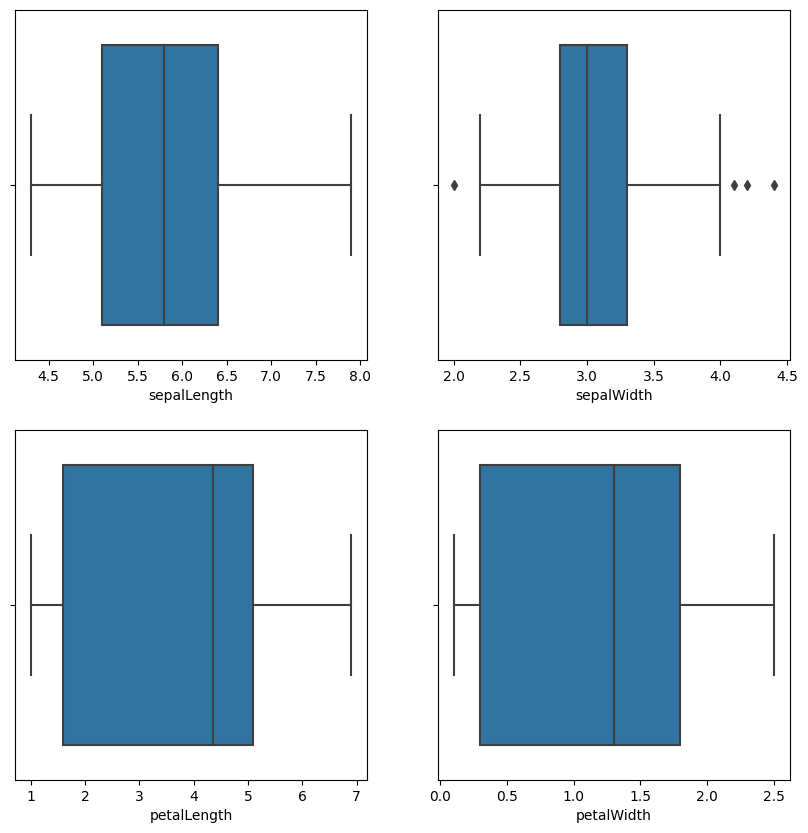

In [ ]:
def graph(x):
    sns.boxplot(x=x, data=iris_df.toPandas())

plt.figure(figsize=(10,10))

plt.subplot(221)
graph('sepalLength')

plt.subplot(222)
graph('sepalWidth')

plt.subplot(223)
graph('petalLength')

plt.subplot(224)
graph('petalWidth')

plt.show()

# **Sepal width has a few outliers, lets remove them**

shape :  146 , 5


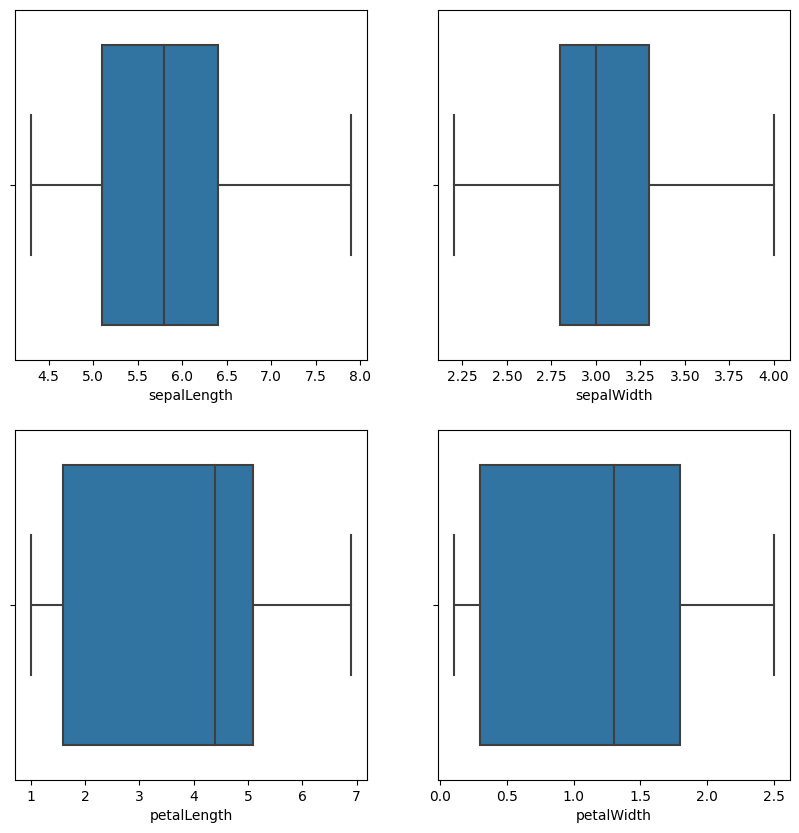

In [ ]:
quantile_values = iris_df.approxQuantile('sepalWidth', [0.25, 0.75], 0.01)
q1,q3 = quantile_values[0],quantile_values[1]
iqr = q3 - q1
lower_lim = q1 - 1.5 * iqr
upper_lim = q3 + 1.5 * iqr
iris_df = iris_df.filter((col('sepalWidth') >= lower_lim) & (col('sepalWidth') <= upper_lim))
print("shape : ",iris_df.count(),',',len(iris_df.columns))
plt.figure(figsize=(10,10))

plt.subplot(221)
graph('sepalLength')

plt.subplot(222)
graph('sepalWidth')

plt.subplot(223)
graph('petalLength')

plt.subplot(224)
graph('petalWidth')

plt.show()

# **This confirms high correlation between petal length and petal width**

1.  We can remove one of the columns with high correlation



In [ ]:
correlation_matrix = iris_df.toPandas().corr()
correlation_matrix

,sepalLength,sepalWidth,petalLength,petalWidth
sepalLength,1.000000,-0.113977,0.879374,0.822577
sepalWidth,-0.113977,1.000000,-0.397123,-0.329782
petalLength,0.879374,-0.397123,1.000000,0.961755
petalWidth,0.822577,-0.329782,0.961755,1.000000


<Axes: >

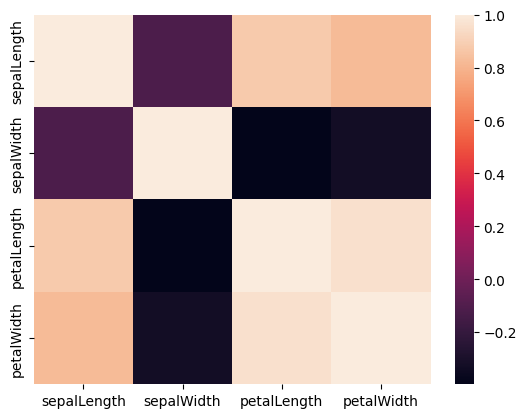

In [ ]:
sns.heatmap(correlation_matrix)

In [ ]:
#iris_df=iris_df.drop("petalWidth")   #-- removing this is not improving performance metrics on test set

In [ ]:
feature_cols = iris_df.columns[:-1]
vect_assembler = VectorAssembler(inputCols = feature_cols, outputCol="input_vector")
#Utilize Assembler created above in order to add the feature column
iris_df_features = vect_assembler.transform(iris_df)

In [ ]:
iris_df_features.show(5)

+-----------+----------+-----------+----------+-----------+--------------------+
|sepalLength|sepalWidth|petalLength|petalWidth|      Class|        input_vector|
+-----------+----------+-----------+----------+-----------+--------------------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|[5.09999990463256...|
|        4.9|       3.0|        1.4|       0.2|Iris-setosa|[4.90000009536743...|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|[4.69999980926513...|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|[4.59999990463256...|
|        5.0|       3.6|        1.4|       0.2|Iris-setosa|[5.0,3.5999999046...|
+-----------+----------+-----------+----------+-----------+--------------------+
only showing top 5 rows



# **Min-Max scaler transformation**




In [ ]:
scaler = MinMaxScaler(inputCol="input_vector", outputCol="X")
scaler=scaler.fit(iris_df_features)
iris_df_features=scaler.transform(iris_df_features)

In [ ]:
iris_df_features.show(5)

+-----------+----------+-----------+----------+-----------+--------------------+--------------------+
|sepalLength|sepalWidth|petalLength|petalWidth|      Class|        input_vector|                   X|
+-----------+----------+-----------+----------+-----------+--------------------+--------------------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|[5.09999990463256...|[0.22222214863623...|
|        4.9|       3.0|        1.4|       0.2|Iris-setosa|[4.90000009536743...|[0.16666664459087...|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|[4.69999980926513...|[0.11111100809073...|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|[4.59999990463256...|[0.08333325606805...|
|        5.0|       3.6|        1.4|       0.2|Iris-setosa|[5.0,3.5999999046...|[0.19444439661355...|
+-----------+----------+-----------+----------+-----------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
iris_df_final=iris_df_features.select("X","Class")

In [ ]:
iris_df_final.show()

+--------------------+-----------+
|                   X|      Class|
+--------------------+-----------+
|[0.22222214863623...|Iris-setosa|
|[0.16666664459087...|Iris-setosa|
|[0.11111100809073...|Iris-setosa|
|[0.08333325606805...|Iris-setosa|
|[0.19444439661355...|Iris-setosa|
|[0.30555553715905...|Iris-setosa|
|[0.08333325606805...|Iris-setosa|
|[0.19444439661355...|Iris-setosa|
|[0.02777775202268...|Iris-setosa|
|[0.16666664459087...|Iris-setosa|
|[0.30555553715905...|Iris-setosa|
|[0.13888889256818...|Iris-setosa|
|[0.13888889256818...|Iris-setosa|
|[0.0,0.4444444297...|Iris-setosa|
|[0.41666667770456...|Iris-setosa|
|[0.30555553715905...|Iris-setosa|
|[0.22222214863623...|Iris-setosa|
|[0.38888879322711...|Iris-setosa|
|[0.22222214863623...|Iris-setosa|
|[0.30555553715905...|Iris-setosa|
+--------------------+-----------+
only showing top 20 rows



In [ ]:
indexer = StringIndexer(inputCol="Class", outputCol="Y")
indexerModel = indexer.fit(iris_df_final)
indexed_df = indexerModel.transform(iris_df_final)
indexed_df=indexed_df.drop("Class")

In [ ]:
indexerModel.labels

['Iris-virginica', 'Iris-versicolor', 'Iris-setosa']

In [ ]:
index_to_string_label = IndexToString(inputCol="Y", outputCol="label_Category",
                                labels=indexerModel.labels)
index_to_string_pred = IndexToString(inputCol="prediction", outputCol="prediction_Category",
                                labels=indexerModel.labels)

# **4.	Data Preparation**
a.	Do the final feature selection and extract them into Column X and the class label into Column into Y.

b.	Split the dataset into training and test sets


In [ ]:
indexed_df.show()

+--------------------+---+
|                   X|  Y|
+--------------------+---+
|[0.22222214863623...|2.0|
|[0.16666664459087...|2.0|
|[0.11111100809073...|2.0|
|[0.08333325606805...|2.0|
|[0.19444439661355...|2.0|
|[0.30555553715905...|2.0|
|[0.08333325606805...|2.0|
|[0.19444439661355...|2.0|
|[0.02777775202268...|2.0|
|[0.16666664459087...|2.0|
|[0.30555553715905...|2.0|
|[0.13888889256818...|2.0|
|[0.13888889256818...|2.0|
|[0.0,0.4444444297...|2.0|
|[0.41666667770456...|2.0|
|[0.30555553715905...|2.0|
|[0.22222214863623...|2.0|
|[0.38888879322711...|2.0|
|[0.22222214863623...|2.0|
|[0.30555553715905...|2.0|
+--------------------+---+
only showing top 20 rows



In [ ]:
train_dataset, test_dataset = indexed_df.randomSplit([0.8, 0.2],seed = 31)

In [ ]:
train_dataset.describe().show()

+-------+------------------+
|summary|                 Y|
+-------+------------------+
|  count|               111|
|   mean|0.9369369369369369|
| stddev|0.8232891823685512|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



In [ ]:
test_dataset.describe().show()

+-------+------------------+
|summary|                 Y|
+-------+------------------+
|  count|                35|
|   mean|1.1142857142857143|
| stddev|0.7959983953364171|
|    min|               0.0|
|    max|               2.0|
+-------+------------------+



# **5.	Model Building**
a.	Perform Model Development using at least three models

b.	 Train the model and print the training accuracy and loss values


In [ ]:
#Import Logistic Regression class
from pyspark.ml.classification import LogisticRegression
LogReg = LogisticRegression(featuresCol="X", labelCol="Y")
#Train the model on the training using fit() method.
lr_model = LogReg.fit(train_dataset)
#Predict the Class using the evaluate method
lr_pred = lr_model.transform(train_dataset)
lr_pred.show()
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Y")
evaluator.setPredictionCol("prediction")
print('LogisticRegression Train Accuracy :',evaluator.evaluate(lr_pred, {evaluator.metricName: "accuracy"}))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",probabilityCol="probability",labelCol="Y")
evaluator.setMetricName("logLoss")
print('Train Loss : ',evaluator.evaluate(lr_pred))

+--------------------+---+--------------------+--------------------+----------+
|                   X|  Y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.02777775202268...|2.0|[-53.320940105683...|[1.52302125245347...|       2.0|
|[0.05555550404536...|2.0|[-36.937707443843...|[3.94693798614475...|       2.0|
|[0.08333325606805...|2.0|[-60.258382169442...|[1.13713685467421...|       2.0|
|[0.08333325606805...|2.0|[-74.373075879293...|[1.42408381306280...|       2.0|
|[0.11111100809073...|2.0|[-61.012779830774...|[2.96189072811794...|       2.0|
|[0.11111100809073...|2.0|[-57.918354259604...|[2.83499222194943...|       2.0|
|[0.13888889256818...|2.0|[-56.864255689388...|[5.39677950528152...|       2.0|
|[0.13888889256818...|2.0|[-52.555395598636...|[8.80654430666191...|       2.0|
|[0.13888889256818...|2.0|[-55.144072399520...|[6.98047611524835...|       2.0|
|[0.16666664459087...|1.0|[-2.6160908526

In [ ]:
#Import RandomForest Classifier class
from pyspark.ml.classification import RandomForestClassifier
RFC = RandomForestClassifier(featuresCol="X", labelCol="Y")
#Train the model on the training using fit() method.
rfc_model = RFC.fit(train_dataset)
#Predict the Class using the evaluate method
rfc_pred = rfc_model.transform(train_dataset)
rfc_pred.show()
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Y")
evaluator.setPredictionCol("prediction")
print('RandomForestClassifier Train Accuracy :',evaluator.evaluate(rfc_pred, {evaluator.metricName: "accuracy"}))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",probabilityCol="probability",labelCol="Y")
evaluator.setMetricName("logLoss")
print('Train Loss : ',evaluator.evaluate(rfc_pred))

+--------------------+---+--------------------+--------------------+----------+
|                   X|  Y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.02777775202268...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.05555550404536...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.11111100809073...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.11111100809073...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.16666664459087...|1.0|[1.10344827586

In [ ]:
#Import DecisionTreeClassifier class
from pyspark.ml.classification import DecisionTreeClassifier
DTC = DecisionTreeClassifier(featuresCol="X", labelCol="Y")
#Train the model on the training using fit() method.
dtc_model = DTC.fit(train_dataset)
#Predict the Class using the evaluate method
dtc_pred = dtc_model.transform(train_dataset)
dtc_pred.show()
evaluator = MulticlassClassificationEvaluator()
evaluator.setLabelCol("Y")
evaluator.setPredictionCol("prediction")
print('DecisionTreeClassifier Train Accuracy :',evaluator.evaluate(dtc_pred, {evaluator.metricName: "accuracy"}))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",probabilityCol="probability",labelCol="Y")
evaluator.setMetricName("logLoss")
print('Train Loss : ',evaluator.evaluate(dtc_pred))

+--------------------+---+--------------+-------------+----------+
|                   X|  Y| rawPrediction|  probability|prediction|
+--------------------+---+--------------+-------------+----------+
|[0.02777775202268...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.05555550404536...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.11111100809073...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.11111100809073...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.16666664459087...|1.0|[0.0,34.0,0.0]|[0.0,1.0,0.0]|       1.0|
|[0.16666664459087...|0.0| [3.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|[0.16666664459087...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       

# **6.	Performance Evaluation**
a.	Print the confusion matrix.

b.	Do the prediction for the test data and display the results for the inference.



1.   Precision : Precision should ideally be 1 (high) for a good classifier. It refers to the values that are predicted +ve correctly out of all values that are predicted +ve
2.   Recall : Recall should ideally be 1 (high) for a good classifier. It refers to the values that are predicted +ve correctly out of all values that are actually positive
3.   F1 Score : Ideally in a good classifier, we want both precision and recall to be one which also means FP and FN are zero. Therefore we need a metric that takes into account both precision and recall. F1-score is a metric which is harmonic mean of precision and recall
4.   Accuracy : Accuracy should be high for a good classifier. It represents the number of correctly classified data instances over the total number of data instances.







> **Logistic Regression**



In [ ]:
predictions = lr_model.transform(test_dataset)
predictions.show()
preds_and_labels = predictions.select(['prediction','Y'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print('Confusion Matrix : \n',metrics.confusionMatrix().toArray())
precision_class_0 = metrics.precision(0.0)
recall_class_0 = metrics.recall(0.0)
f1Score_class_0 = metrics.fMeasure(0.0)
precision_class_1 = metrics.precision(1.0)
recall_class_1 = metrics.recall(1.0)
f1Score_class_1 = metrics.fMeasure(1.0)
precision_class_2 = metrics.precision(2.0)
recall_class_2 = metrics.recall(2.0)
f1Score_class_2 = metrics.fMeasure(2.0)
accuracy = metrics.accuracy
print("Summary Stats Logistic regression")
print("precision_class_0 = ",precision_class_0)
print("precision_class_1 = ",precision_class_1)
print("precision_class_2 = ",precision_class_2)
print("recall_class_0 = ",recall_class_0)
print("recall_class_1 = ",recall_class_1)
print("recall_class_2 = ",recall_class_2)
print("F1 Score Class_0 = ",f1Score_class_0)
print("F1 Score Class_1 = ",f1Score_class_1)
print("F1 Score Class_2 = ",f1Score_class_2)
print("F1 Score macro-averaged = ",(f1Score_class_0+f1Score_class_1+f1Score_class_2)/3)
print("Accuracy = ",accuracy)
preds_and_labels=index_to_string_label.transform(preds_and_labels)
preds_and_labels=index_to_string_pred.transform(preds_and_labels)

+--------------------+---+--------------------+--------------------+----------+
|                   X|  Y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.0,0.4444444297...|2.0|[-61.344068997444...|[5.05900198887303...|       2.0|
|[0.02777775202268...|2.0|[-56.849612352103...|[1.61115806091084...|       2.0|
|[0.02777775202268...|2.0|[-61.844012417949...|[1.75112561928860...|       2.0|
|[0.08333325606805...|2.0|[-56.729703969236...|[1.07494850437478...|       2.0|
|[0.08333325606805...|2.0|[-63.098352109654...|[1.57880099724934...|       2.0|
|[0.13888889256818...|2.0|[-62.635675475182...|[7.90952168007087...|       2.0|
|[0.13888889256818...|2.0|[-59.541251133626...|[7.57062746095356...|       2.0|
|[0.16666664459087...|2.0|[-54.432748195213...|[1.76964952752650...|       2.0|
|[0.16666664459087...|2.0|[-58.052900025969...|[1.42333128702759...|       2.0|
|[0.22222214863623...|2.0|[-66.364590324



**Predicted Vs label comparison Logistic Regression**



In [ ]:
preds_and_labels.show()

+----------+---+---------------+-------------------+
|prediction|  Y| label_Category|prediction_Category|
+----------+---+---------------+-------------------+
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       1.0|1.0|Iris-versicolor|    Iris-versicolor|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       1.0|1.0|Iris-versicolor|    Iris-versicolor|
|       1.0|1.0|Iris-versicolor|    Iris-versi




> Random Forest









In [ ]:
predictions = rfc_model.transform(test_dataset)
predictions.show()
preds_and_labels = predictions.select(['prediction','Y'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print('Confusion Matrix : \n',metrics.confusionMatrix().toArray())
precision_class_0 = metrics.precision(0.0)
recall_class_0 = metrics.recall(0.0)
f1Score_class_0 = metrics.fMeasure(0.0)
precision_class_1 = metrics.precision(1.0)
recall_class_1 = metrics.recall(1.0)
f1Score_class_1 = metrics.fMeasure(1.0)
precision_class_2 = metrics.precision(2.0)
recall_class_2 = metrics.recall(2.0)
f1Score_class_2 = metrics.fMeasure(2.0)
accuracy = metrics.accuracy
print("Summary Stats Logistic regression")
print("precision_class_0 = ",precision_class_0)
print("precision_class_1 = ",precision_class_1)
print("precision_class_2 = ",precision_class_2)
print("recall_class_0 = ",recall_class_0)
print("recall_class_1 = ",recall_class_1)
print("recall_class_2 = ",recall_class_2)
print("F1 Score Class_0 = ",f1Score_class_0)
print("F1 Score Class_1 = ",f1Score_class_1)
print("F1 Score Class_2 = ",f1Score_class_2)
print("F1 Score macro-averaged = ",(f1Score_class_0+f1Score_class_1+f1Score_class_2)/3)
print("Accuracy = ",accuracy)
preds_and_labels=index_to_string_label.transform(preds_and_labels)
preds_and_labels=index_to_string_pred.transform(preds_and_labels)

+--------------------+---+--------------------+--------------------+----------+
|                   X|  Y|       rawPrediction|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[0.0,0.4444444297...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.02777775202268...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.02777775202268...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|[0.10344827586206...|[0.00517241379310...|       2.0|
|[0.16666664459087...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.16666664459087...|2.0|      [0.0,0.0,20.0]|       [0.0,0.0,1.0]|       2.0|
|[0.22222214863623...|2.0|      [0.0,0.0

**Predicted Vs label comparison Random Forest**

In [ ]:
preds_and_labels.show()

+----------+---+---------------+-------------------+
|prediction|  Y| label_Category|prediction_Category|
+----------+---+---------------+-------------------+
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       1.0|1.0|Iris-versicolor|    Iris-versicolor|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       1.0|1.0|Iris-versicolor|    Iris-versicolor|
|       1.0|1.0|Iris-versicolor|    Iris-versi



>Decision tree classifier



In [ ]:
predictions = dtc_model.transform(test_dataset)
predictions.show()
preds_and_labels = predictions.select(['prediction','Y'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print('Confusion Matrix : \n',metrics.confusionMatrix().toArray())
precision_class_0 = metrics.precision(0.0)
recall_class_0 = metrics.recall(0.0)
f1Score_class_0 = metrics.fMeasure(0.0)
precision_class_1 = metrics.precision(1.0)
recall_class_1 = metrics.recall(1.0)
f1Score_class_1 = metrics.fMeasure(1.0)
precision_class_2 = metrics.precision(2.0)
recall_class_2 = metrics.recall(2.0)
f1Score_class_2 = metrics.fMeasure(2.0)
accuracy = metrics.accuracy
print("Summary Stats Logistic regression")
print("precision_class_0 = ",precision_class_0)
print("precision_class_1 = ",precision_class_1)
print("precision_class_2 = ",precision_class_2)
print("recall_class_0 = ",recall_class_0)
print("recall_class_1 = ",recall_class_1)
print("recall_class_2 = ",recall_class_2)
print("F1 Score Class_0 = ",f1Score_class_0)
print("F1 Score Class_1 = ",f1Score_class_1)
print("F1 Score Class_2 = ",f1Score_class_2)
print("F1 Score macro-averaged = ",(f1Score_class_0+f1Score_class_1+f1Score_class_2)/3)
print("Accuracy = ",accuracy)
preds_and_labels=index_to_string_label.transform(preds_and_labels)
preds_and_labels=index_to_string_pred.transform(preds_and_labels)

+--------------------+---+--------------+-------------+----------+
|                   X|  Y| rawPrediction|  probability|prediction|
+--------------------+---+--------------+-------------+----------+
|[0.0,0.4444444297...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.02777775202268...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.02777775202268...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.08333325606805...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.13888889256818...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.16666664459087...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.16666664459087...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.22222214863623...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.24999990065892...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       2.0|
|[0.27777778513637...|2.0|[0.0,0.0,34.0]|[0.0,0.0,1.0]|       

**Predicted Vs label comparison Decision Tree Classifier**

In [ ]:
preds_and_labels.show()

+----------+---+---------------+-------------------+
|prediction|  Y| label_Category|prediction_Category|
+----------+---+---------------+-------------------+
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       1.0|1.0|Iris-versicolor|    Iris-versicolor|
|       2.0|2.0|    Iris-setosa|        Iris-setosa|
|       1.0|1.0|Iris-versicolor|    Iris-versicolor|
|       1.0|1.0|Iris-versicolor|    Iris-versi

# **Based on F1 Score(takes into account both precision & recall) logistic regression & Decision tree classifier are performing best on test set**

In [ ]:
%%shell
jupyter nbconvert --to html ./Group05_IrisDataset.ipynb

[NbConvertApp] Converting notebook ./Group05_IrisDataset.ipynb to html
[NbConvertApp] Writing 874994 bytes to Group05_IrisDataset.html
